In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
df = pd.read_csv('/content/heart_cleveland_upload (1) (1).csv')
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [4]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')


In [5]:
if 'target' not in df.columns and 'condition' in df.columns:
    df['target'] = df['condition'].apply(lambda x: 1 if x > 0 else 0)
    df.drop('condition', axis=1, inplace=True)

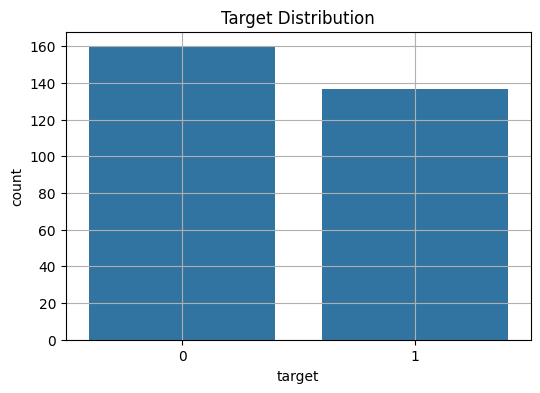

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target')
plt.title("Target Distribution")
plt.grid()
plt.show()

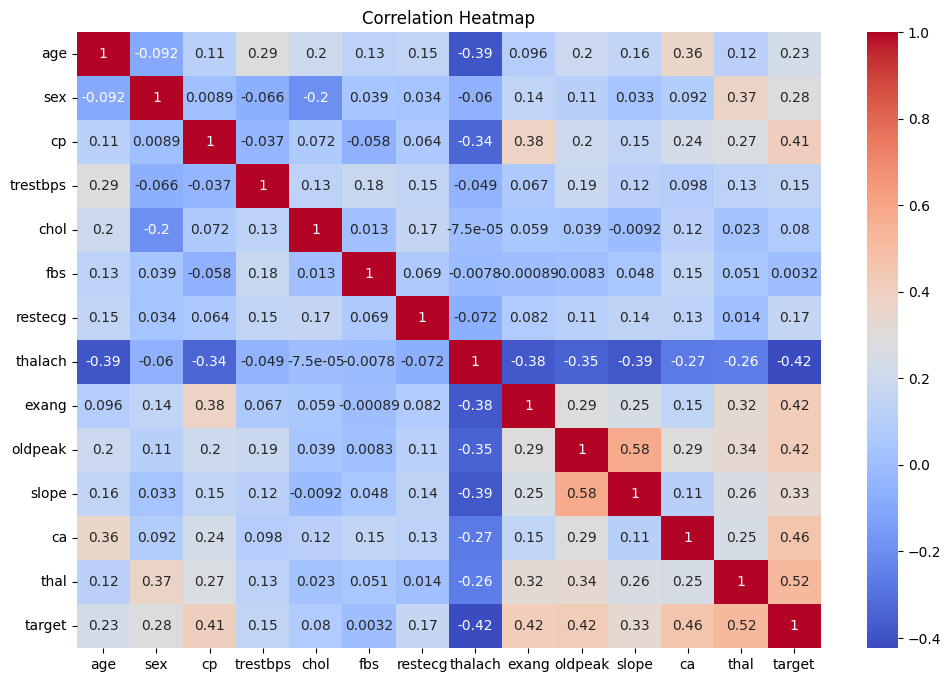

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

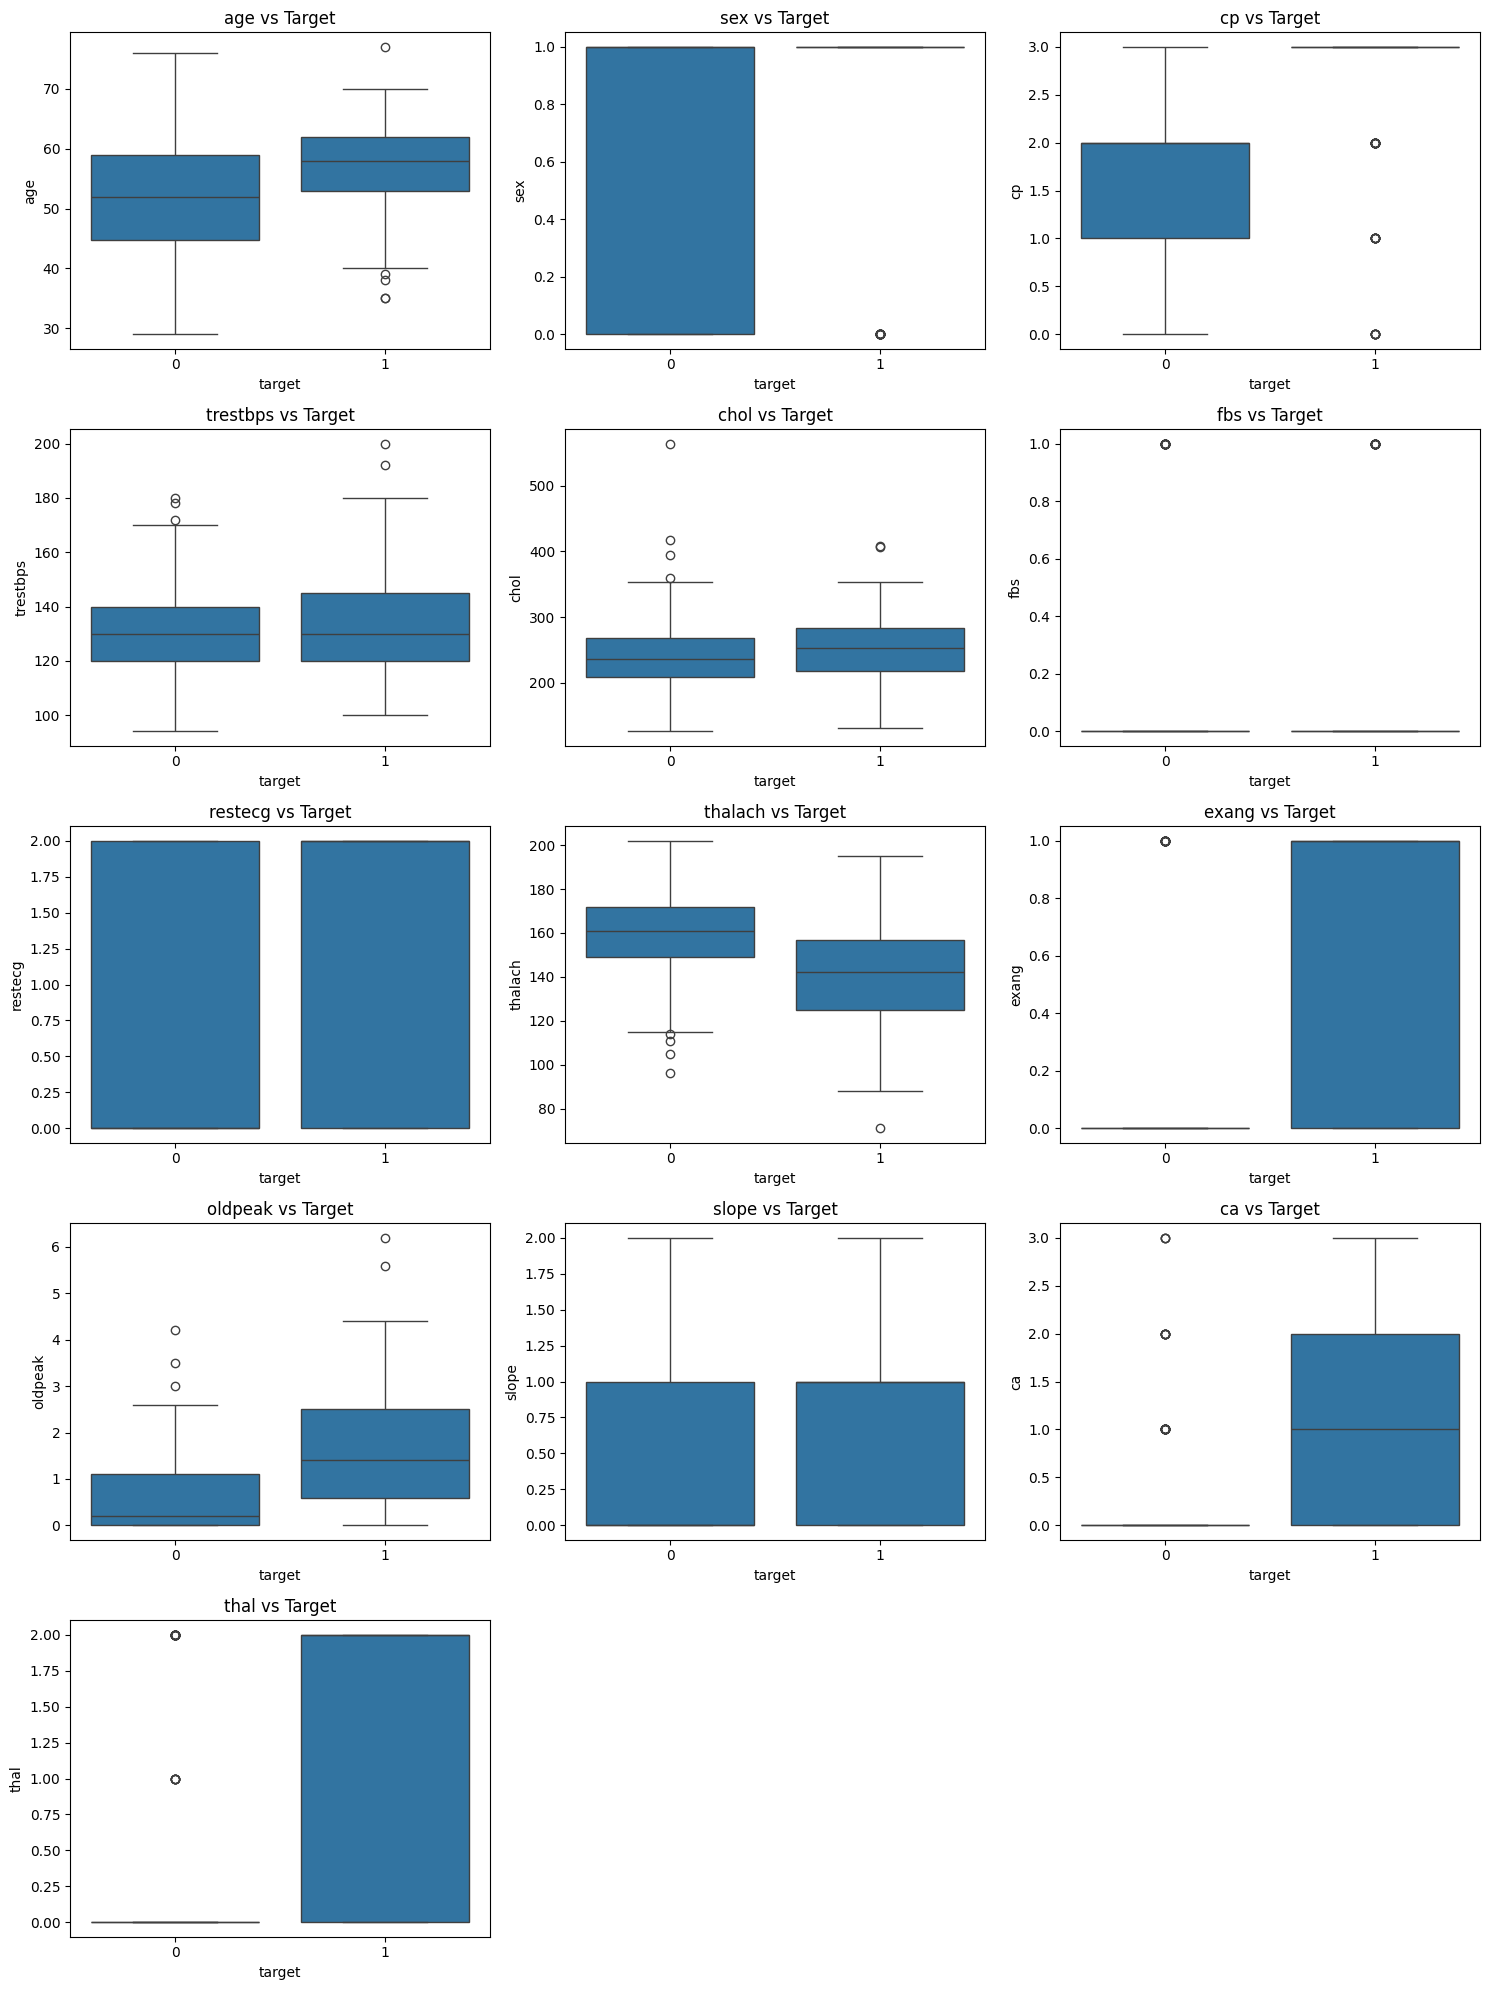

In [8]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('target')

num_plots = len(numerical_cols)
cols = 3
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=df, x='target', y=col)
    plt.title(f'{col} vs Target')
    plt.tight_layout()
plt.show()

In [9]:
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [11]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [13]:
# Neural Network
model = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, verbose=0)
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [14]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [15]:
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Neural Network", y_test, y_pred_nn)


Model: Logistic Regression
Accuracy: 0.7333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.70      0.75      0.72        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60

Confusion Matrix:
 [[23  9]
 [ 7 21]]

Model: Decision Tree
Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67        32
           1       0.62      0.64      0.63        28

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60

Confusion Matrix:
 [[21 11]
 [10 18]]

Model: Random Forest
Accuracy: 0.7
Classification Report:
               precision    recall  f1-score   support

           0 

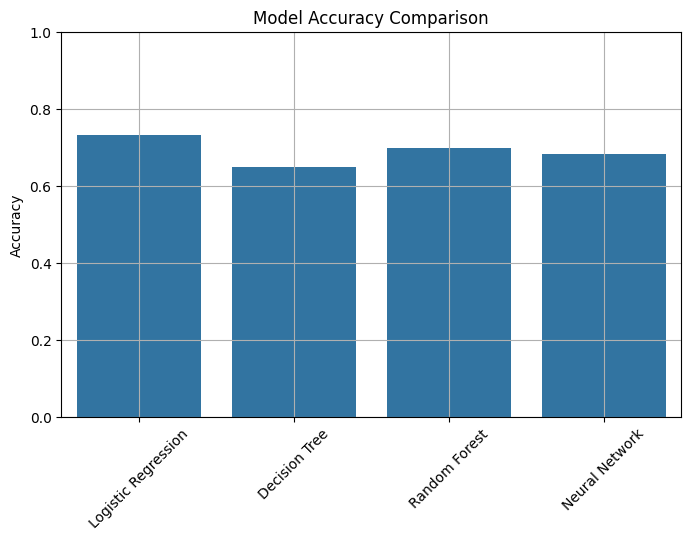

In [16]:
accuracy_scores = {
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Neural Network": accuracy_score(y_test, y_pred_nn)
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid()
plt.show()

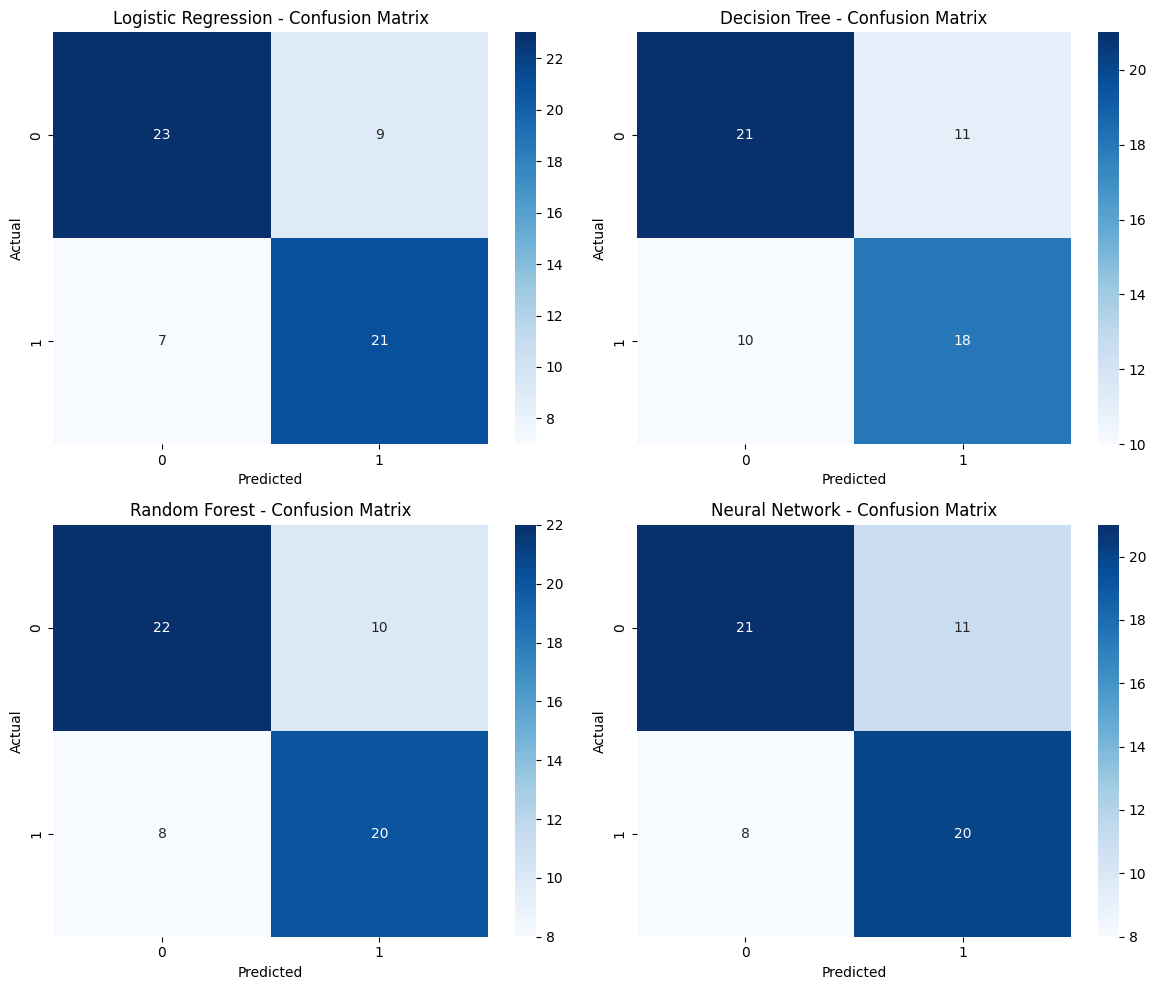

In [17]:
models_preds = {
    "Logistic Regression": y_pred_lr,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Neural Network": y_pred_nn.flatten()
}

plt.figure(figsize=(12, 10))
for i, (name, pred) in enumerate(models_preds.items()):
    cm = confusion_matrix(y_test, pred)
    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
plt.tight_layout()
plt.show()

def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        if name == "Neural Network":
            y_score = model.predict(X_test).ravel()
        else:
            y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc = roc_auc_score(y_test, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC-AUC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curves({
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Neural Network": model
}, X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


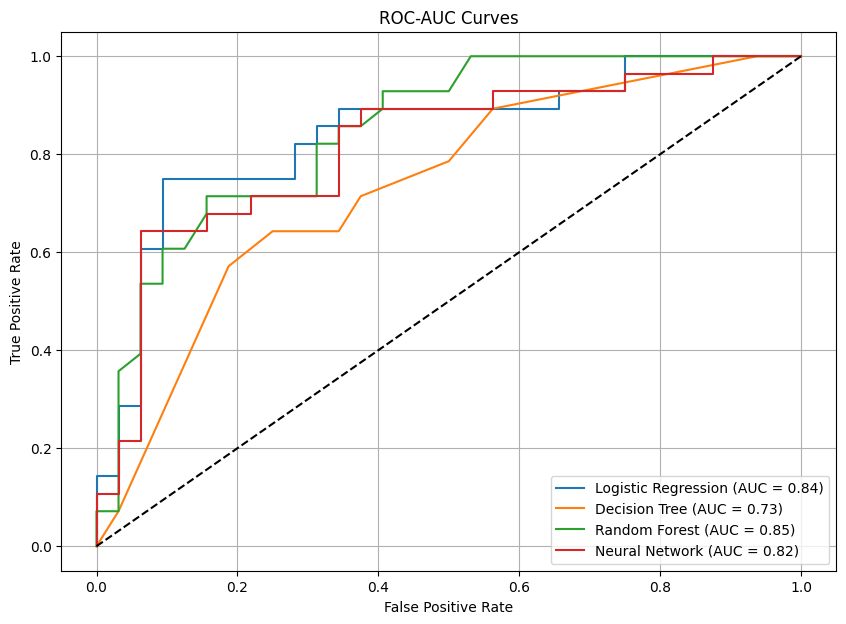

In [25]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        if name == "Neural Network":
            y_score = model.predict(X_test).ravel()
        else:
            y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc = roc_auc_score(y_test, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC-AUC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curves({
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Neural Network": model
}, X_test, y_test)

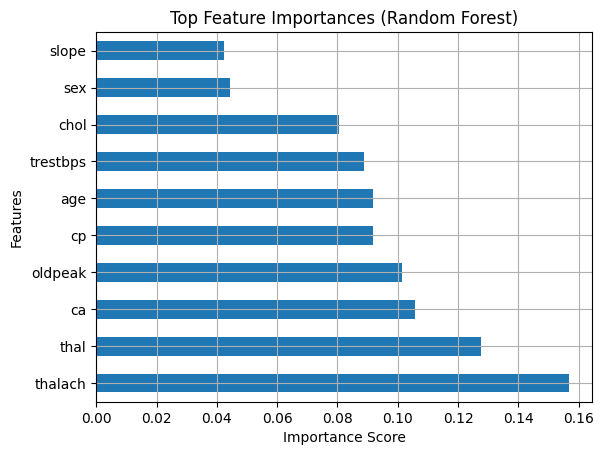

In [26]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid()
plt.show()

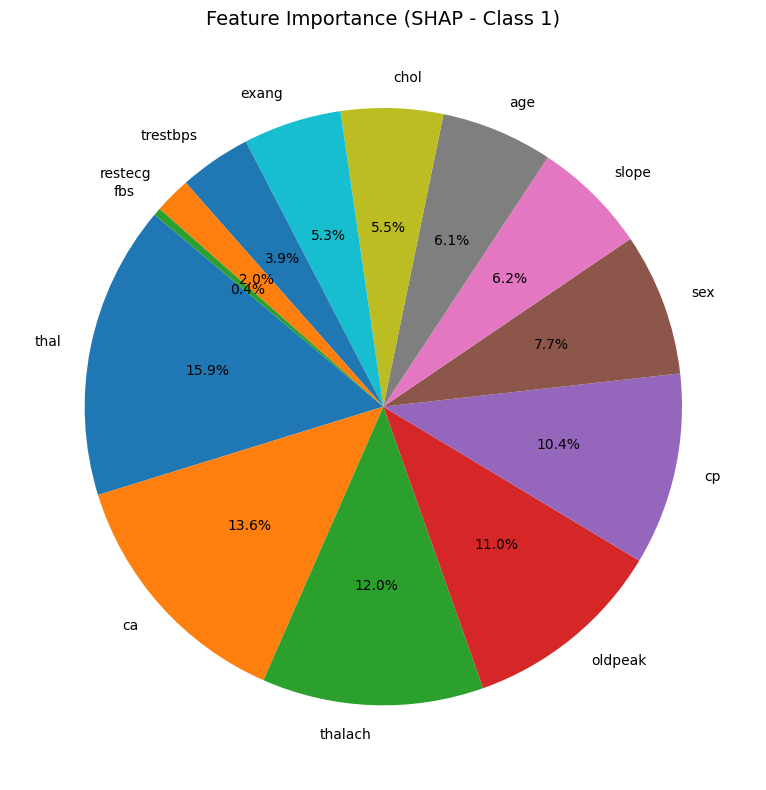

In [30]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_vals_class1 = shap_values[:, :, 1]
mean_abs_shap = np.abs(shap_vals_class1).mean(axis=0)
feature_importance = pd.Series(mean_abs_shap, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 8))
plt.pie(feature_importance, labels=feature_importance.index, autopct='%1.1f%%', startangle=140)
plt.title('Feature Importance (SHAP - Class 1)', fontsize=14)
plt.tight_layout()
plt.show()